#📌 Extracão

In [189]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xgboost as xgb
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_validate
from yellowbrick.model_selection import FeatureImportances
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
dadosNormais = pd.read_csv('dados_tratados.csv')



In [190]:
def preprocess_data(dadosNormais):
    dadosNormais = dadosNormais.copy()

    # Remover colunas irrelevantes
    dadosNormais.drop(columns=['idcliente', 'meses_contrato_trimestre'], inplace=True, errors='ignore')

    # Remover espaços em branco dos nomes das colunas
    dadosNormais.columns = dadosNormais.columns.str.strip()

    # Tratar valores nulos
    dadosNormais.replace(" ", np.nan, inplace=True)
    dadosNormais.dropna(inplace=True)

    # Converter colunas numéricas quando possível
    for col in dadosNormais.columns:
        try:
            dadosNormais[col] = pd.to_numeric(dadosNormais[col])
        except:
            pass

    # Colunas de serviços que entram no contador
    servicos = [
        'servico_telefone','multiplas_linhas','servico_de_internet','antivirus',
        'backup','protecao__de_dipositivo','suporte_tecnico','streaming_tv',
        'streaming_filmes','fatura_digital'
    ]

    # Transformar colunas de serviços em booleanos
    for col in servicos:
        dadosNormais[col] = dadosNormais[col].apply(
            lambda x: True if str(x).strip().lower() in ['1','sim','yes','true'] else False
        )

    # Transformar idoso, parceiro e dependentes em booleanos
    for col in ['idoso', 'parceiro', 'dependentes','evasao']:
        dadosNormais[col] = dadosNormais[col].astype(bool)

    # Criar totalServicos somando apenas os serviços
    dadosNormais['totalServicos'] = dadosNormais[servicos].sum(axis=1)

    return dadosNormais
dadosNormais = preprocess_data(dadosNormais)
dadosNormais.head()


,evasao,genero,idoso,parceiro,dependentes,meses_contrato,servico_telefone,multiplas_linhas,servico_de_internet,antivirus,...,suporte_tecnico,streaming_tv,streaming_filmes,tipo_contrato,fatura_digital,metodo_pagamento,total_mensal,gasto_total,contas_diarias,totalServicos
0,False,Mulher,False,True,True,9,True,False,False,False,...,True,True,False,one year,True,mailed check,65.6,593.30,2.186667,5
1,False,Homem,False,False,False,9,True,True,False,False,...,False,False,True,month-to-month,False,mailed check,59.9,542.40,1.996667,3
2,True,Homem,False,False,False,4,True,False,False,False,...,False,False,False,month-to-month,True,electronic check,73.9,280.85,2.463333,3
3,True,Homem,True,True,False,13,True,False,False,False,...,False,True,True,month-to-month,True,electronic check,98.0,1237.85,3.266667,6
4,True,Mulher,True,True,False,3,True,False,False,False,...,True,True,False,month-to-month,True,mailed check,83.9,267.40,2.796667,4


In [191]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

# Separando Variaveis
X = dadosNormais.drop('evasao', axis=1)
y = dadosNormais['evasao']

# Transformar variáveis categóricas em numéricas (One-Hot Encoding)
X_encoded = pd.get_dummies(X, drop_first=True, dtype=int)

# Remover colunas constantes
X_encoded = X_encoded.loc[:, X_encoded.nunique() > 1]

# normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Seleção de variáveis
k = min(10, X_encoded.shape[1])  # garante que k não seja maior que o nº de colunas
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X_encoded.columns[selector.get_support()].tolist()

print("Variáveis mais relevantes:", selected_features)


# ========================
# Análise do balanceamento
# ========================

countEvasao = y.value_counts()
taxaEvasao = countEvasao / len(y)

print("\nProporção de Classes:")
print(f"- Clientes Ativos (0): {countEvasao.iloc[0]} ({taxaEvasao.iloc[0]:.2%})")
print(f"- Clientes Inativos (1): {countEvasao.iloc[1]} ({taxaEvasao.iloc[1]:.2%})")

# classes desbalanceadas podem impactar na performance dos modelos
imbalance_threshold = 0.40
if taxaEvasao.min() < imbalance_threshold:
    print("\n Desequilíbrio detectado entre as classes!")
    print()
else:
    print("\n Classes balanceadas.")


Variáveis mais relevantes: ['meses_contrato', 'antivirus', 'suporte_tecnico', 'fatura_digital', 'total_mensal', 'gasto_total', 'contas_diarias', 'tipo_contrato_one year', 'tipo_contrato_two year', 'metodo_pagamento_electronic check']

Proporção de Classes:
- Clientes Ativos (0): 5163 (73.42%)
- Clientes Inativos (1): 1869 (26.58%)

 Desequilíbrio detectado entre as classes!



# Fazendo uso do Dummy

In [192]:
# -----------------------------
# Codificação de variáveis categóricas
# -----------------------------
variaveis_categoricas = [
    'servico_telefone','multiplas_linhas','servico_de_internet','antivirus',
    'backup','protecao__de_dipositivo','suporte_tecnico','streaming_tv','streaming_filmes',
    'tipo_contrato','fatura_digital','metodo_pagamento','genero'
]

# Codifica variáveis categóricas em 0/1 e remove colunas constantes
dadosCodificados = pd.get_dummies(dadosNormais, columns=variaveis_categoricas, dtype=int, dummy_na=False)
dadosCodificados = dadosCodificados.loc[:, dadosCodificados.var() > 0]

# Divide os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Cria uma instância do DummyRegressor
model_dummy = DummyRegressor()

# Ajusta o modelo DummyRegressor aos dados de treinamento
model_dummy.fit(X_train, y_train)

# Realiza previsões usando o modelo DummyRegressor nos dados de teste
y_pred_dummy = model_dummy.predict(X_test)

def calcular_metricas_regressao(y_test, y_pred):
    # MSE
    mse = mean_squared_error(y_test, y_pred)
    # RMSE compatível com versões antigas e novas
    try:
        rmse = mean_squared_error(y_test, y_pred, squared=False)
    # Caso incompativel, ele calcula o rmse 'manualmente'
    except TypeError:
        rmse = np.sqrt(mse)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {
        'Raiz do Erro Quadrático Médio': round(rmse, 4),
        'Erro Absoluto Médio': round(mae, 4),
        'R2 Score': round(r2, 4)
    }


# Calcula e exibe as métricas do modelo DummyRegressor
calcular_metricas_regressao(y_test, y_pred_dummy)


{'Raiz do Erro Quadrático Médio': np.float64(0.4441),
 'Erro Absoluto Médio': 0.3917,
 'R2 Score': -0.0002}

#🔧 Tratamento

Classes após SMOTE: evasao
False    3609
True     3609
Name: count, dtype: int64
Features selecionadas pelo SelectKBest: ['meses_contrato', 'gasto_total', 'antivirus_False', 'antivirus_True', 'tipo_contrato_month-to-month', 'tipo_contrato_one year', 'tipo_contrato_two year', 'fatura_digital_False', 'fatura_digital_True', 'metodo_pagamento_electronic check']

Random Forest Classifier com SMOTE - Features Selecionadas
              precision    recall  f1-score   support

       False       0.84      0.79      0.81      1554
        True       0.50      0.58      0.54       556

    accuracy                           0.73      2110
   macro avg       0.67      0.69      0.67      2110
weighted avg       0.75      0.73      0.74      2110

ROC AUC: 0.7820101062007536
10 melhores features combinadas (SelectKBest + RandomForest):


,0
gasto_total,0.365365
meses_contrato,0.249477
tipo_contrato_month-to-month,0.153350
metodo_pagamento_electronic check,0.073010
tipo_contrato_two year,0.055487
tipo_contrato_one year,0.025865
fatura_digital_True,0.023322
fatura_digital_False,0.023188
antivirus_True,0.015754
antivirus_False,0.015183


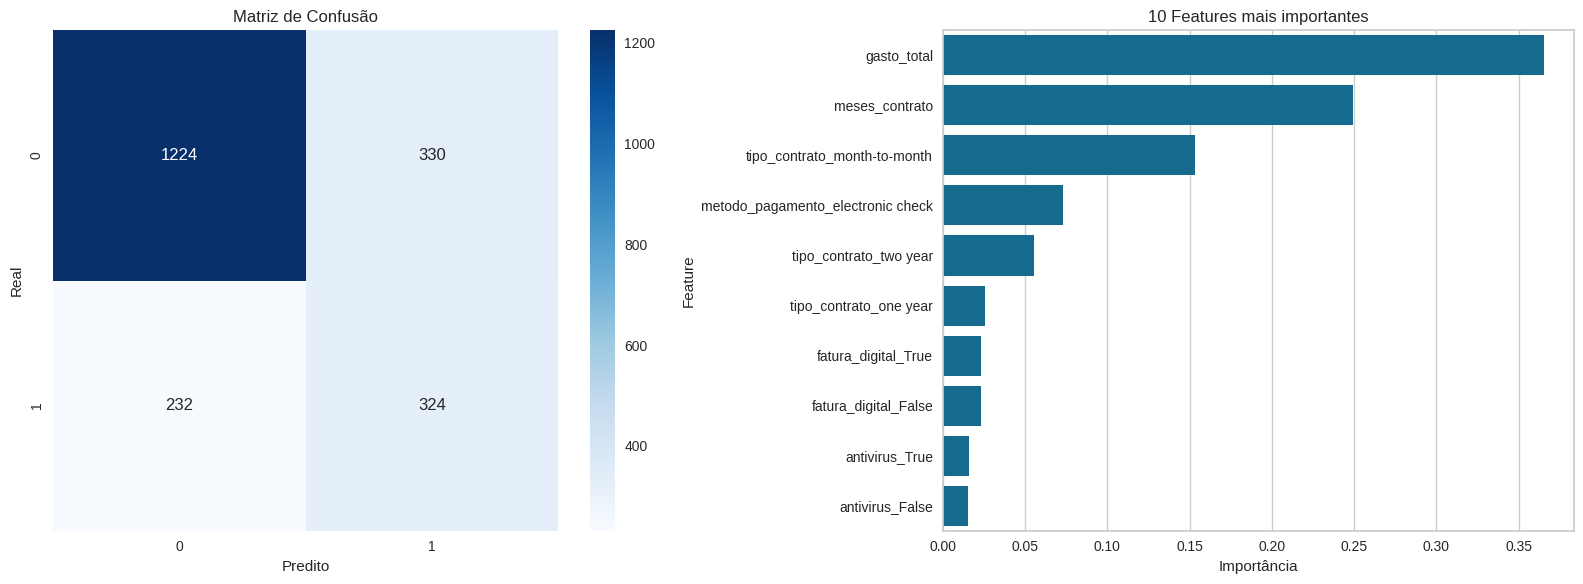

In [193]:

# Separar features e target
X = dadosCodificados.drop(columns=['evasao'])
y = dadosCodificados['evasao']

# Divisão treino/teste antes do balanceamento
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Escalonamento das variáveis numéricas
scaler = StandardScaler()
# fit_transform no treino: calcula média e desvio padrão e aplica a padronização
X_train_scaled = scaler.fit_transform(X_train)
# transform no teste: aplica a mesma padronização do treino, evitando data leakage
X_test_scaled = scaler.transform(X_test)


# Aplicação do SMOTE
smote = SMOTE(random_state=42)
# Balanceia as classes do treino criando amostras sintéticas da minoria
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)
print("Classes após SMOTE:", pd.Series(y_train_bal).value_counts())

# Seleção das 10 melhores features com SelectKBest (univariado)
selector = SelectKBest(score_func=f_classif, k=10)
X_train_sel = selector.fit_transform(X_train_bal, y_train_bal)
X_test_sel = X_test_scaled[:, selector.get_support()]
features_kbest = X.columns[selector.get_support()].tolist()
print("Features selecionadas pelo SelectKBest:", features_kbest)

# Treinamento do RandomForestClassifier com features selecionadas
modeloRandomForest = RandomForestClassifier(n_estimators=100, random_state=42)
modeloRandomForest.fit(X_train_sel, y_train_bal)

y_pred = modeloRandomForest.predict(X_test_sel)
y_proba = modeloRandomForest.predict_proba(X_test_sel)[:, 1]

# Métricas de avaliação
print("\nRandom Forest Classifier com SMOTE - Features Selecionadas")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Combinar importância do RandomForest e SelectKBest
importancias_rf = pd.Series(modeloRandomForest.feature_importances_, index=features_kbest)

# Top 10 do RandomForest
melhoresFeaturesRF = importancias_rf.sort_values(ascending=False).head(10)

# Top 10 combinadas (em ordem de RandomForest, mas filtrando apenas SelectKBest)
melhoresFeatures = melhoresFeaturesRF[melhoresFeaturesRF.index.isin(features_kbest)]
print("10 melhores features combinadas (SelectKBest + RandomForest):")
display(melhoresFeatures)

# Visualizações lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Matriz de Confusão")
axes[0].set_xlabel("Predito")
axes[0].set_ylabel("Real")

# Top 10 features
sns.barplot(x=melhoresFeatures.values, y=melhoresFeatures.index, ax=axes[1])
axes[1].set_title("10 Features mais importantes")
axes[1].set_xlabel("Importância")
axes[1].set_ylabel("Feature")

plt.tight_layout()
plt.show()



Proporção de Classes:
- Clientes Ativos (0): 5163 (73.42%)
- Clientes Evasivos (1): 1869 (26.58%)


/tmp/ipython-input-978411664.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"- Clientes Ativos (0): {countEvasao[0]} ({taxaEvasao[0]:.2%})")
/tmp/ipython-input-978411664.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"- Clientes Evasivos (1): {countEvasao[1]} ({taxaEvasao[1]:.2%})")


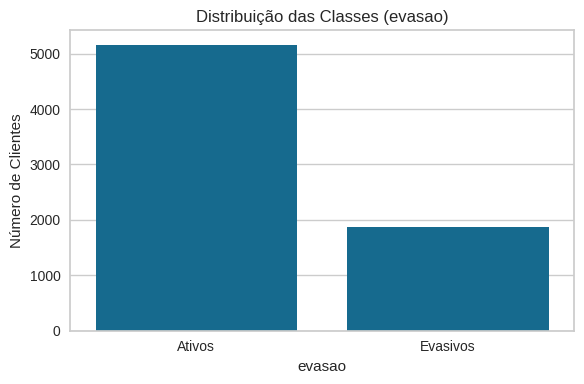


 Aplicando SMOTE para balancear as classes
 Classes após SMOTE: Counter({False: 3609, True: 3609})

 Logistic Regression (SMOTE)
              precision    recall  f1-score   support

       False       0.91      0.72      0.80      1554
        True       0.50      0.79      0.61       556

    accuracy                           0.74      2110
   macro avg       0.70      0.75      0.71      2110
weighted avg       0.80      0.74      0.75      2110

ROC AUC: 0.8324577789505848

 Random Forest (SMOTE)
              precision    recall  f1-score   support

       False       0.86      0.84      0.85      1554
        True       0.57      0.60      0.59       556

    accuracy                           0.78      2110
   macro avg       0.71      0.72      0.72      2110
weighted avg       0.78      0.78      0.78      2110

ROC AUC: 0.807536017518032


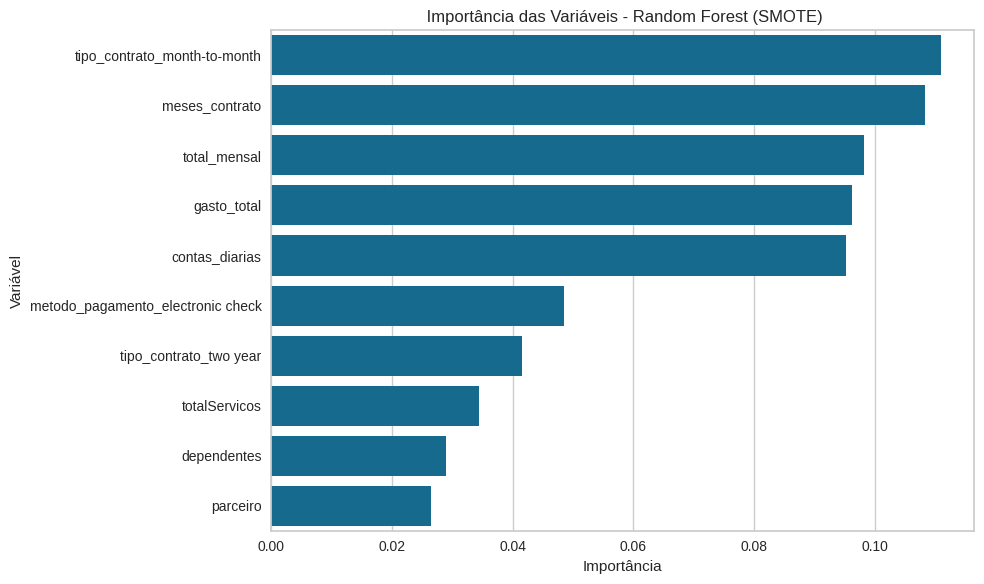

In [194]:
# Verificando a proporção de classes
print("\nProporção de Classes:")
print(f"- Clientes Ativos (0): {countEvasao[0]} ({taxaEvasao[0]:.2%})")
print(f"- Clientes Evasivos (1): {countEvasao[1]} ({taxaEvasao[1]:.2%})")

# Visualização do desequilíbrio
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Distribuição das Classes (evasao)")
plt.xlabel("evasao")
plt.ylabel("Número de Clientes")
plt.xticks([0, 1], ['Ativos', 'Evasivos'])
plt.tight_layout()
plt.show()

# Escalonamento das variáveis numéricas
scaler = StandardScaler()
# fit_transform no treino: calcula média e desvio padrão e aplica a padronização
X_train_scaled = scaler.fit_transform(X_train)
# transform no teste: aplica a mesma padronização do treino, evitando data leakage
X_test_scaled = scaler.transform(X_test)

# Transformar de volta em DataFrame para não perder nomes das colunas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

# Aplicação do SMOTE
print("\n Aplicando SMOTE para balancear as classes")
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)
print(" Classes após SMOTE:", Counter(y_train_bal))

# Treinamento com dados balanceados
models = {
    'Logistic Regression (SMOTE)': LogisticRegression(max_iter=1000),
    'Random Forest (SMOTE)': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    print(f"\n {name}")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))

    results[name] = {
        'model': model,
        'roc_auc': roc_auc_score(y_test, y_proba)
    }

# Importância das variáveis (Random Forest com SMOTE)
rf_model = results['Random Forest (SMOTE)']['model']
importances = pd.Series(rf_model.feature_importances_, index=X.columns)  # agora casa certinho
top_importances = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances.values, y=top_importances.index)
plt.title(" Importância das Variáveis - Random Forest (SMOTE)")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()


In [195]:
# Padronização dos dados com StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Criação do DataFrame dfView com dados padronizados
dfView = pd.DataFrame(X_scaled, columns=X.columns)

# Adiciona a variável alvo 'evasao' ao dfView
dfView['evasao'] = y.values

# Visualização inicial do dfView
print("\n DataFrame dfView - Dados Padronizados (Treino):")
print(dfView.head())
print(dfView.describe())



 DataFrame dfView - Dados Padronizados (Treino):
      idoso  parceiro  dependentes  meses_contrato  total_mensal  gasto_total  \
0 -0.440327  1.035617     1.533025       -0.954296      0.026652    -0.745607   
1 -0.440327 -0.965608    -0.652305       -0.954296     -0.162819    -0.768063   
2 -0.440327 -0.965608    -0.652305       -1.158016      0.302548    -0.883456   
3  2.271039  1.035617    -0.652305       -0.791321      1.103642    -0.461240   
4  2.271039  1.035617    -0.652305       -1.198760      0.634952    -0.889390   

   contas_diarias  totalServicos  servico_telefone_False  \
0        0.026652       0.471191               -0.327189   
1       -0.162819      -0.431524               -0.327189   
2        0.302548      -0.431524               -0.327189   
3        1.103642       0.922548               -0.327189   
4        0.634952       0.019834               -0.327189   

   servico_telefone_True  ...  tipo_contrato_two year  fatura_digital_False  \
0               0.32718


 Correlação com evasao:
evasao                                        1.000000
tipo_contrato_month-to-month                  0.404565
metodo_pagamento_electronic check             0.301455
total_mensal                                  0.192858
contas_diarias                                0.192858
fatura_digital_True                           0.191454
antivirus_False                               0.171270
suporte_tecnico_False                         0.164716
idoso                                         0.150541
backup_False                                  0.082307
protecao__de_dipositivo_False                 0.066193
streaming_tv_True                             0.063254
streaming_filmes_True                         0.060860
multiplas_linhas_True                         0.040033
servico_telefone_True                         0.011691
genero_Mulher                                 0.008545
genero_Homem                                 -0.008545
servico_telefone_False                  

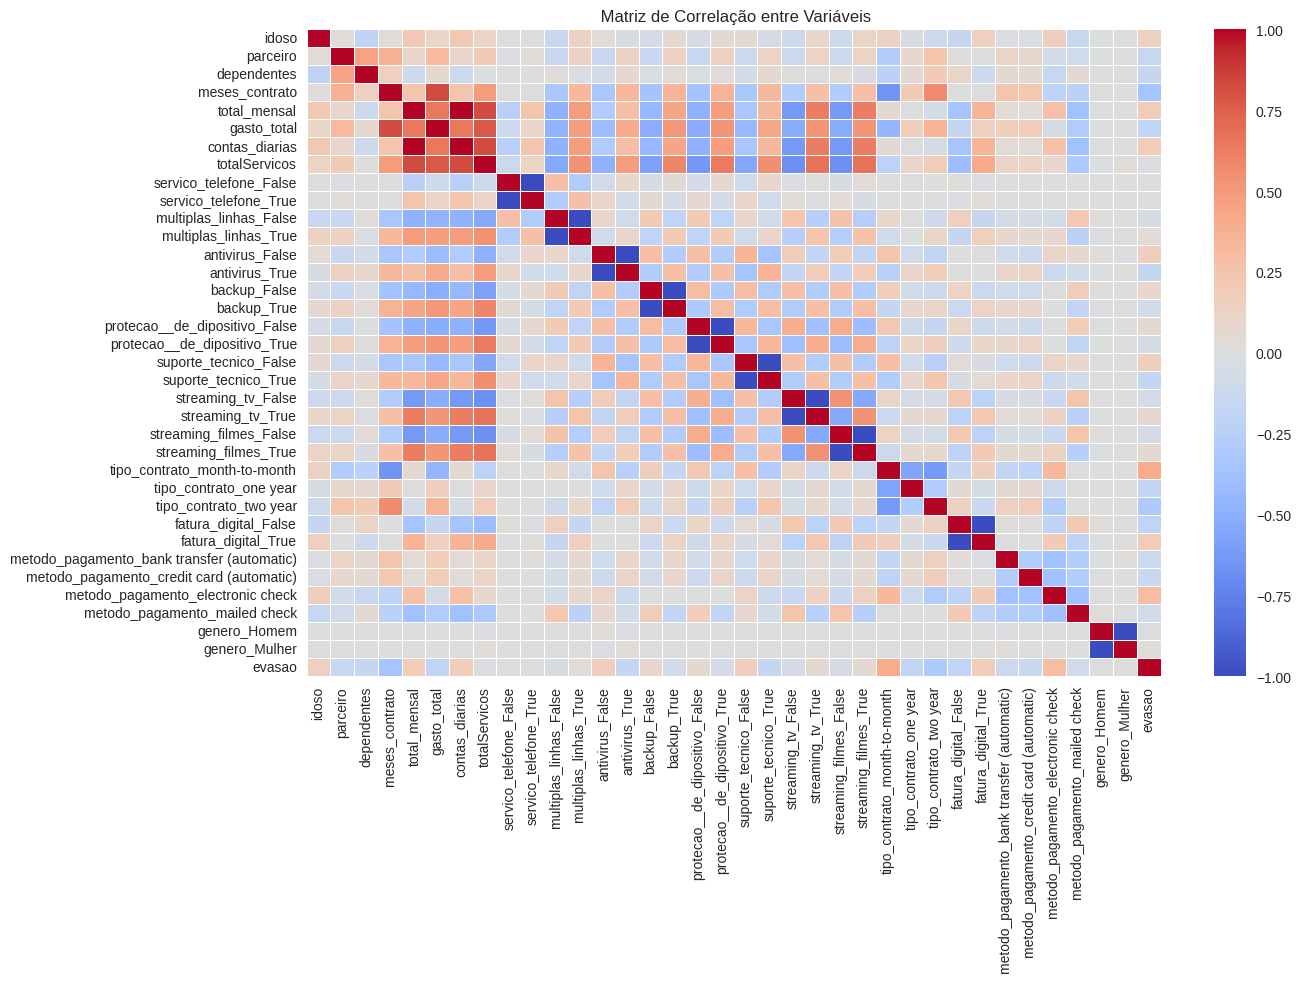

/tmp/ipython-input-946845067.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr_features.values, y=top_corr_features.index, palette='viridis')


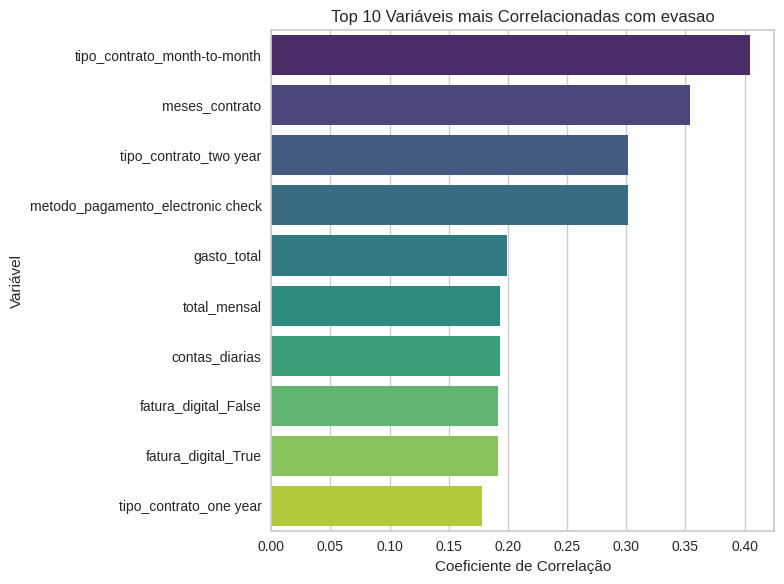

In [196]:
# Matriz de correlação
correlation_matrix = dfView.corr()

# Correlação com a variável alvo 'evasao'
corrComEvasao = correlation_matrix['evasao'].sort_values(ascending=False)

print("\n Correlação com evasao:")
print(corrComEvasao)

# Heatmap da matriz de correlação
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title(" Matriz de Correlação entre Variáveis")
plt.tight_layout()
plt.show()

# Foco nas variáveis mais correlacionadas com evasao
top_corr_features = corrComEvasao.drop('evasao').abs().sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_corr_features.values, y=top_corr_features.index, palette='viridis')
plt.title("Top 10 Variáveis mais Correlacionadas com evasao")
plt.xlabel("Coeficiente de Correlação")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()

/tmp/ipython-input-589299835.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='evasao', y='meses_contrato', data=df2, palette='YlGnBu')


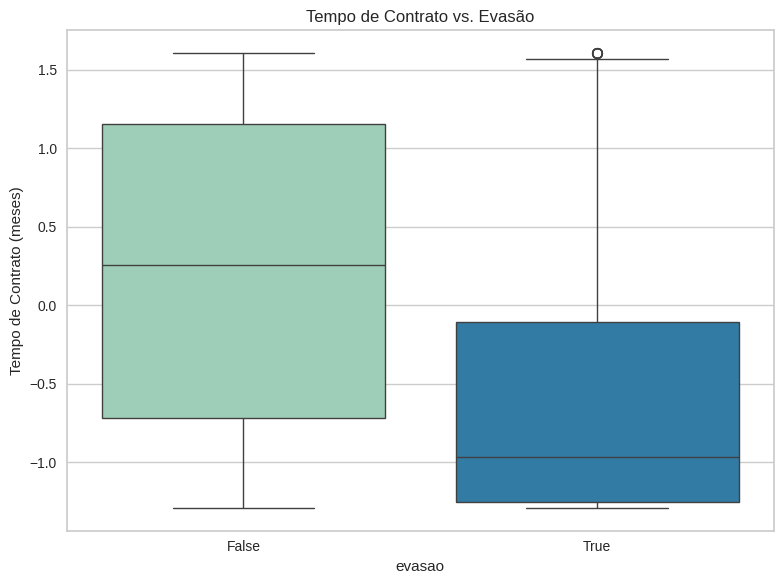

/tmp/ipython-input-589299835.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='evasao', y='gasto_total', data=df2, palette='YlGn')


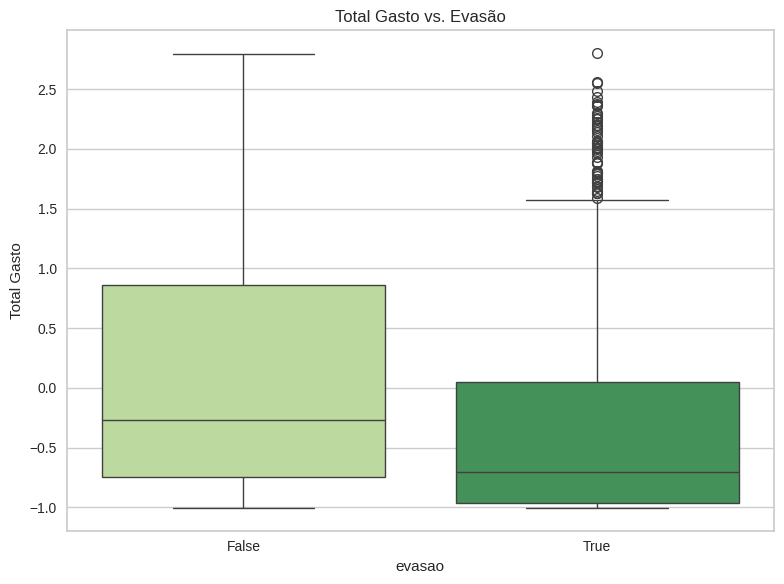

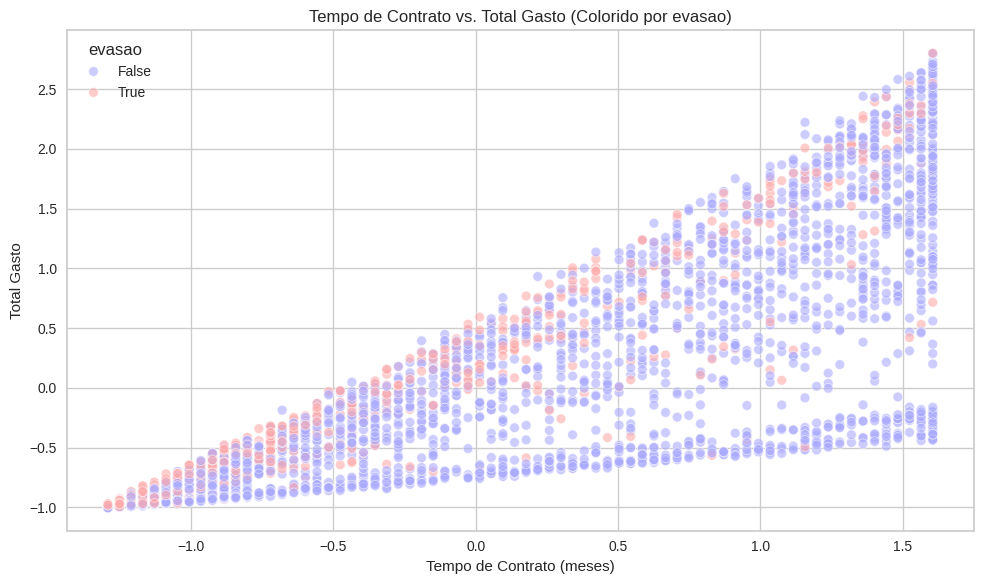

In [197]:
# Boxplot: Tempo de contrato vs. evasao
plt.figure(figsize=(8, 6))
sns.boxplot(x='evasao', y='meses_contrato', data=df2, palette='YlGnBu')
plt.title("Tempo de Contrato vs. Evasão")
plt.xlabel("evasao")
plt.ylabel("Tempo de Contrato (meses)")
plt.tight_layout()
plt.show()

# Boxplot: Total gasto vs. evasao
plt.figure(figsize=(8, 6))
sns.boxplot(x='evasao', y='gasto_total', data=df2, palette='YlGn')
plt.title("Total Gasto vs. Evasão")
plt.xlabel("evasao")
plt.ylabel("Total Gasto")
plt.tight_layout()
plt.show()

# Scatter plot: Tempo de contrato vs. Total gasto, colorido por evasao
plt.figure(figsize=(10, 6))
sns.scatterplot(x='meses_contrato', y='gasto_total', hue='evasao', data=df2, palette='bwr', alpha=0.6)
plt.title("Tempo de Contrato vs. Total Gasto (Colorido por evasao)")
plt.xlabel("Tempo de Contrato (meses)")
plt.ylabel("Total Gasto")
plt.tight_layout()
plt.show()

# Separação de Dados

In [198]:
# Divisão dos dados em treino e teste (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\n Tamanho do conjunto de treino: {X_train.shape[0]} registros")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} registros")


 Tamanho do conjunto de treino: 4922 registros
Tamanho do conjunto de teste: 2110 registros


# Criação de Modelos

A Regressão Logística: é um modelo simples e interpretável, ideal para problemas de classificação binária, como prever se o cliente vai evadir ou não. Além disso, ela permite identificar quais variáveis exercem maior influência na evasão, o que ajuda na tomada de decisão estratégica. Como esse modelo é sensível à escala das variáveis, foi necessário aplicar a normalização para evitar que atributos com valores muito grandes dominassem o processo de ajuste dos parâmetros.

In [199]:



# Divisão dos dados normalizados (dfView)
X2 = dfView.drop('evasao', axis=1)
y2 = dfView['evasao']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42, stratify=y2)

# Modelo 1: Regressão Logística (com dados normalizados)
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X2_train, y2_train)
y2_pred = log_model.predict(X2_test)
y2_proba = log_model.predict_proba(X2_test)[:, 1]

print("\n Modelo 1: Regressão Logística")
print(classification_report(y2_test, y2_pred))
print("ROC AUC:", roc_auc_score(y2_test, y2_proba))

#  Divisão dos dados originais (df with encoding)
X1 = dadosCodificados.drop('evasao', axis=1)
y1 = dadosCodificados['evasao']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42, stratify=y1)




 Modelo 1: Regressão Logística
              precision    recall  f1-score   support

       False       0.84      0.90      0.87      1549
        True       0.66      0.55      0.60       561

    accuracy                           0.80      2110
   macro avg       0.75      0.72      0.73      2110
weighted avg       0.80      0.80      0.80      2110

ROC AUC: 0.845331759090161


O Random Forest: modelo baseado em árvores de decisão, capaz de lidar de forma eficiente com dados que possuem tanto variáveis numéricas quanto categóricas. Ele não exige normalização, pois suas decisões são tomadas por meio de divisões em pontos de corte (limiares) nos atributos. Outra vantagem é a robustez: o modelo consegue capturar relações complexas entre as variáveis, além de ser menos propenso a overfitting quando comparado a uma única árvore de decisão. Por isso, ele tende a apresentar um alto poder preditivo, mesmo em cenários com muitas variáveis ou dados heterogêneos.

In [200]:
# Modelo 2: Random Forest (sem normalização)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X1_train, y1_train)
y1_pred = rf_model.predict(X1_test)
y1_proba = rf_model.predict_proba(X1_test)[:, 1]

print("\n Modelo 2: Random Forest")
print(classification_report(y1_test, y1_pred))
print("ROC AUC:", roc_auc_score(y1_test, y1_proba))


 Modelo 2: Random Forest
              precision    recall  f1-score   support

       False       0.82      0.90      0.86      1549
        True       0.64      0.46      0.54       561

    accuracy                           0.79      2110
   macro avg       0.73      0.68      0.70      2110
weighted avg       0.77      0.79      0.78      2110

ROC AUC: 0.8193929957686462


O modelo de Regressão Logística apresentou melhor desempenho geral, com acurácia de 80%, superando levemente a Random Forest, que atingiu 79%. Na classe de clientes que evadiram (True), a regressão logística obteve recall de 55% (contra 46% da Random Forest) e F1-score de 0.60 (contra 0.54), mostrando-se mais eficaz em identificar clientes que realmente cancelariam, mesmo que isso tenha reduzido um pouco a precisão.

O modelo de Random Forest, embora robusto, apresentou menor capacidade de identificar a classe minoritária (evasores). Ele classificou melhor os clientes que permaneceram (False), mas deixou escapar uma quantidade maior de clientes que efetivamente cancelaram, indicando um possível viés para a classe majoritária.

Quanto a overfitting ou underfitting, não há sinais claros de overfitting em nenhum dos modelos. Entretanto, o desempenho relativamente baixo da Random Forest na classe de evasão sugere dificuldade em generalizar para a minoria, um indício de underfitting nessa classe. A regressão logística, por outro lado, mantém um equilíbrio melhor entre ambas as classes, sem sinais evidentes de overfitting.


 Avaliação do Modelo: Regressão Logística
Acurácia:  0.8038
Precisão:  0.6581
Recall:    0.5455
F1-score:  0.5965


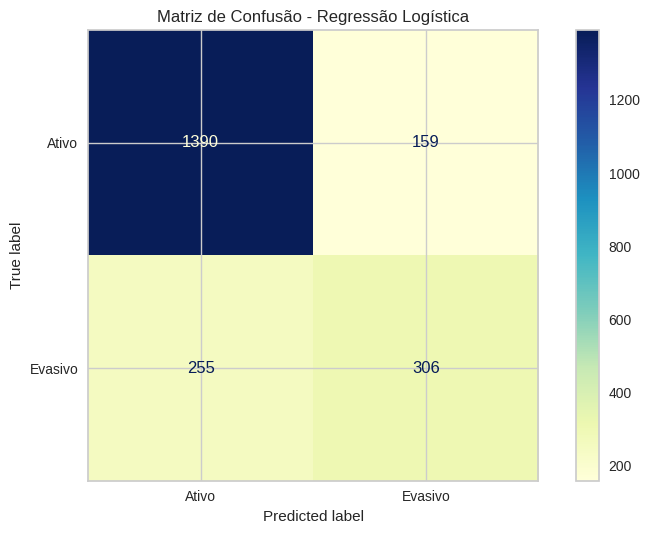


 Avaliação do Modelo: Random Forest
Acurácia:  0.7872
Precisão:  0.6373
Recall:    0.4635
F1-score:  0.5366


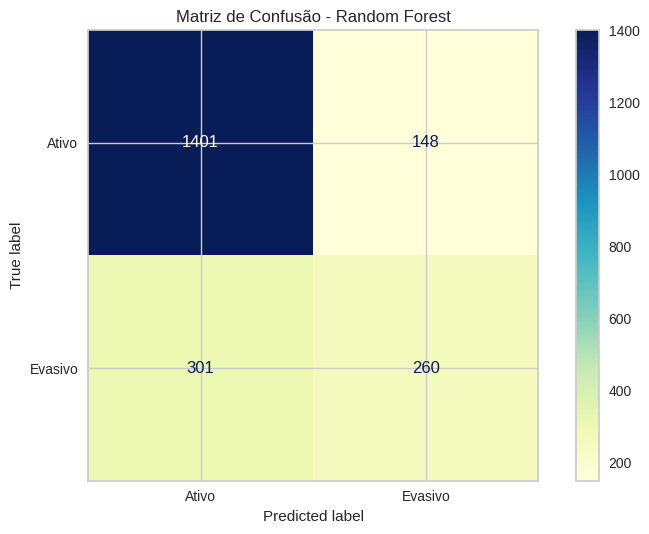

In [201]:
# avaliação dos modelos
def avaliarModelo(name, y_true, y_pred):
    print(f"\n Avaliação do Modelo: {name}")
    print(f"Acurácia:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão:  {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1-score:  {f1_score(y_true, y_pred):.4f}")

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ativo", "Evasivo"])
    disp.plot(cmap='YlGnBu')
    plt.title(f"Matriz de Confusão - {name}")
    plt.tight_layout()
    plt.show()

# Avaliação dos modelos
avaliarModelo("Regressão Logística", y2_test, y2_pred)
avaliarModelo("Random Forest", y1_test, y1_pred)


 Avaliação do Modelo: Gradient Boosting
Acurácia:  0.8019
Precisão:  0.6614
Recall:    0.5223
F1-score:  0.5837


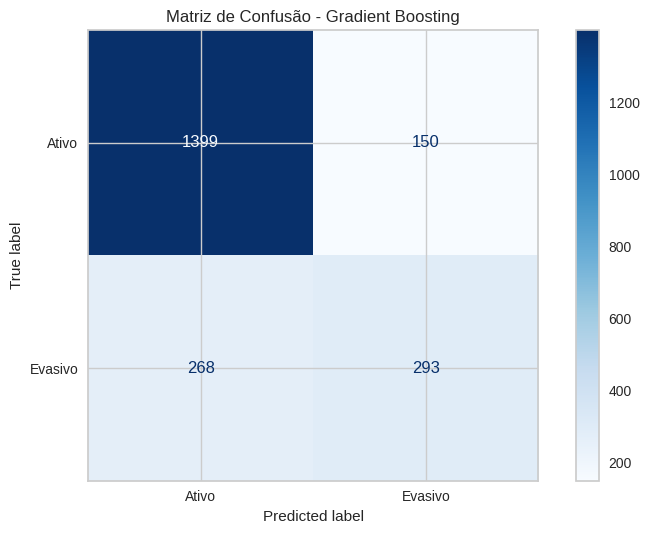

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [00:01:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Avaliação do Modelo: XGBoost
Acurácia:  0.7782
Precisão:  0.5947
Recall:    0.5205
F1-score:  0.5551


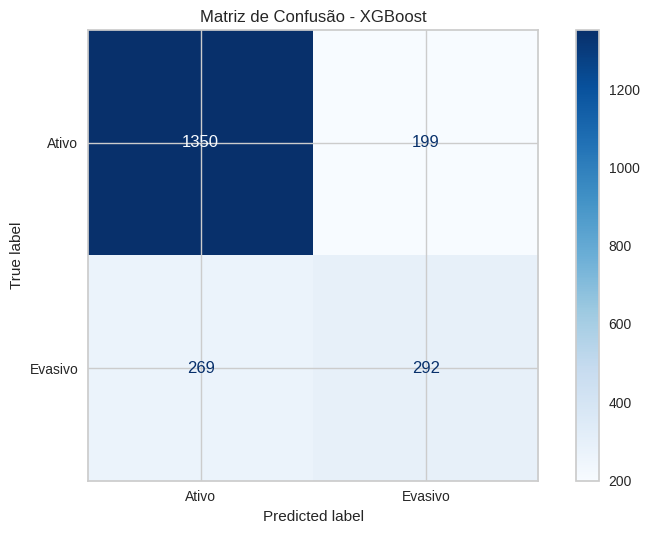

In [202]:
# Tentativa de novos modelos

# modelo 1:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

evaluate_model("Gradient Boosting", y_test, y_pred_gb)

# Modelo 2:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

evaluate_model("XGBoost", y_test, y_pred_xgb)


 Avaliação do Modelo: Regressão Logística - Original
Acurácia:  0.8038
Precisão:  0.6581
Recall:    0.5455
F1-score:  0.5965


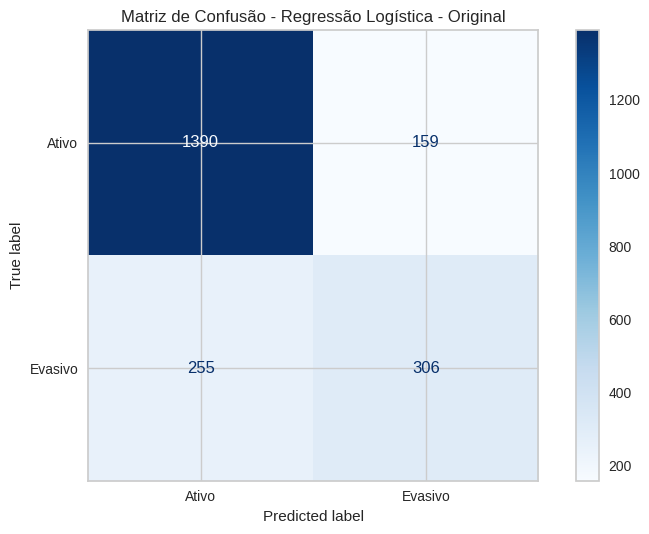


 Avaliação do Modelo: Regressão Logística - Melhorias (threshold=0.35)
Acurácia:  0.6682
Precisão:  0.4403
Recall:    0.9144
F1-score:  0.5944


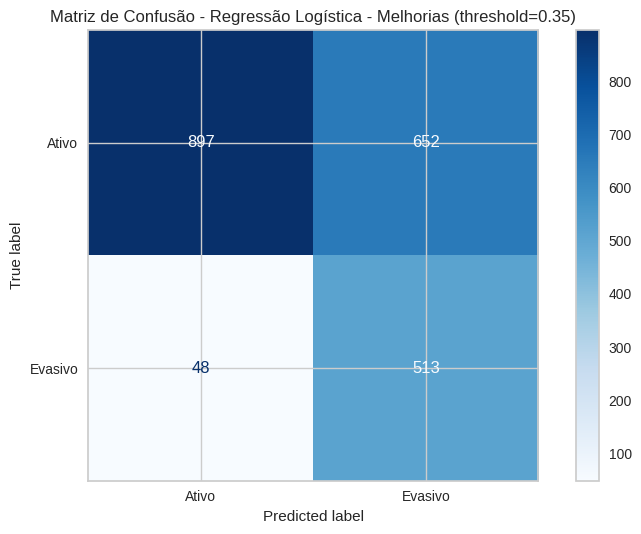

In [203]:
# melhoria do modelo de regressão logistica: o melhor modelo

# 1. Modelo original (sem melhorias)
model_original = LogisticRegression(random_state=42)
model_original.fit(X_train, y_train)
y_pred_original = model_original.predict(X_test)
evaluate_model("Regressão Logística - Original", y_test, y_pred_original)

# 2. Modelo com melhorias
model_improved = LogisticRegression(
    class_weight='balanced',       # Balanceamento de classes
    penalty='l2',                  # Regularização L2
    solver='liblinear',           # Compatível com L2 e class_weight
    random_state=42
)

# Validação cruzada para robustez
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_proba_cv = cross_val_predict(model_improved, X_train, y_train, cv=cv, method='predict_proba')

# Treinamento final no conjunto completo
model_improved.fit(X_train, y_train)
y_proba_test = model_improved.predict_proba(X_test)[:, 1]

# Ajuste do threshold de decisão
threshold = 0.35  # Valor ajustado para aumentar recall
y_pred_adjusted = (y_proba_test >= threshold).astype(int)

evaluate_model(f"Regressão Logística - Melhorias (threshold={threshold})", y_test, y_pred_adjusted)

# Análise dos Modelos
## Modelo Original
Acurácia alta (≈80%) e precisão razoável (≈66%), mas recall limitado (≈55%).
Pode deixar passar muitos casos de evasão (falsos negativos).
Mais conservador: só prevê evasão quando há maior certeza, favorecendo clientes que não evadem.

## Modelo Melhorado (threshold = 0.35)
Recall altíssimo (≈91%), excelente para detectar clientes que realmente evadem.
Queda na precisão (≈44%) e na acurácia (≈67%), indicando aumento de falsos positivos.
F1-score quase equivalente ao modelo original (≈0.59), mostrando equilíbrio entre precisão e recall.
# Interpretação Estratégica
Se o objetivo principal é identificar o máximo de clientes que irão evadir, mesmo que isso gere alguns alarmes falsos, o modelo melhorado é claramente superior.
Em churn prediction, recall é mais valioso: é melhor agir sobre um cliente que talvez não evada do que perder um que realmente vai.

#Escolha Final: Melhor Modelo

Regressão Logística com melhorias e threshold ajustado.

## Por quê?

Detecta quase todos os casos de evasão (recall ≈91%).

Mantém um F1-score semelhante ao modelo original, equilibrando precisão e recall.
Pode ser ajustado ainda mais para encontrar o ponto ideal entre recall e precisão, dependendo do custo de falsos positivos e falsos negativos.

In [204]:
# Treino do modelo
modeloFinal = LogisticRegression(
    class_weight='balanced',
    penalty='l2',
    solver='liblinear',
    random_state=42
)
modeloFinal.fit(X_train, y_train)

# 5️⃣ Obter coeficientes
coefficients = modeloFinal.coef_[0]

# 6️⃣ Criar DataFrame com nomes garantidos
coef_df = pd.DataFrame({
    'Variável': feature_names,
    'Coeficiente': coefficients,
    'Impacto': np.where(coefficients > 0, 'Aumenta evasão', 'Reduz evasão')
}).sort_values(by='Coeficiente', key=abs, ascending=False)

# 10 Melhores variaveis
print("\nVariáveis mais relevantes para a previsão de evasão:")
print(coef_df.head(10))



Variáveis mais relevantes para a previsão de evasão:
                             Variável  Coeficiente         Impacto
3                      meses_contrato    -1.233145    Reduz evasão
5                         gasto_total     0.566288  Aumenta evasão
4                        total_mensal     0.445933  Aumenta evasão
6                      contas_diarias     0.445933  Aumenta evasão
26             tipo_contrato_two year    -0.309434    Reduz evasão
24       tipo_contrato_month-to-month     0.303404  Aumenta evasão
9               servico_telefone_True    -0.147298    Reduz evasão
8              servico_telefone_False     0.147298  Aumenta evasão
31  metodo_pagamento_electronic check     0.145509  Aumenta evasão
18              suporte_tecnico_False     0.111128  Aumenta evasão



 Variáveis mais relevantes para a previsão de evasão:
                             Variável  Coeficiente           Impacto
3                      meses_contrato    -1.233145    ↓ Reduz evasão
5                         gasto_total     0.566288  ↑ Aumenta evasão
4                        total_mensal     0.445933  ↑ Aumenta evasão
6                      contas_diarias     0.445933  ↑ Aumenta evasão
26             tipo_contrato_two year    -0.309434    ↓ Reduz evasão
24       tipo_contrato_month-to-month     0.303404  ↑ Aumenta evasão
9               servico_telefone_True    -0.147298    ↓ Reduz evasão
8              servico_telefone_False     0.147298  ↑ Aumenta evasão
31  metodo_pagamento_electronic check     0.145509  ↑ Aumenta evasão
18              suporte_tecnico_False     0.111128  ↑ Aumenta evasão


/tmp/ipython-input-3802406217.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_df['Coeficiente'].head(10), y=coef_df['Variável'].head(10), palette='viridis')


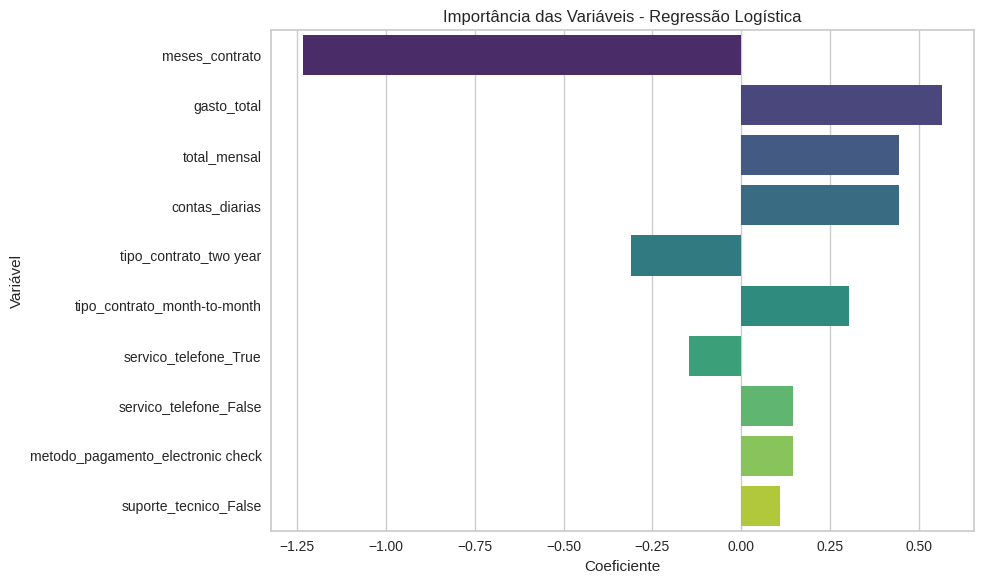

In [205]:
# Treinar novamente o modelo com melhorias
modeloFinal = LogisticRegression(
    class_weight='balanced',
    penalty='l2',
    solver='liblinear',
    random_state=42
)
modeloFinal.fit(X_train, y_train)

# Obter os coeficientes
coefficients = modeloFinal.coef_[0]
features = X.columns

# Criar DataFrame ordenado
coef_df = pd.DataFrame({
    'Variável': features,
    'Coeficiente': coefficients,
    'Impacto': np.where(coefficients > 0, '↑ Aumenta evasão', '↓ Reduz evasão')
}).sort_values(by='Coeficiente', key=abs, ascending=False)

# Exibir os principais
print("\n Variáveis mais relevantes para a previsão de evasão:")
print(coef_df.head(10))

# Plotando
plt.figure(figsize=(10, 6))
sns.barplot(x=coef_df['Coeficiente'].head(10), y=coef_df['Variável'].head(10), palette='viridis')
plt.title("Importância das Variáveis - Regressão Logística")
plt.xlabel("Coeficiente")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()

In [206]:
import pickle

# Salva o modelo treinado como arquivo .pkl
with open('modeloTreinado.pkl', 'wb') as file:
    pickle.dump(model_final, file)

print("Modelo salvo com sucesso como 'modeloTreinado.pkl'")

Modelo salvo com sucesso como 'modeloTreinado.pkl'


# 📊 Relatório de Análise de Evasão de Clientes

# 1. 🎯 Objetivo
Identificar os principais fatores que influenciam a evasão de clientes e avaliar modelos preditivos para antecipar esse comportamento, visando propor estratégias eficazes de retenção.

# 2. ⚗️ Modelos Avaliados
Quatro modelos foram treinados e comparados:

| Modelo                        | Acurácia | Precisão | Recall | F1-score |
|-------------------------------|----------|----------|--------|----------|
| Regressão Logística            | 0.8038   | 0.6581   | 0.5455 | 0.5965   |
| Random Forest                  | 0.7872   | 0.6373   | 0.4635 | 0.5366   |
| Gradient Boosting              | 0.8019   | 0.6614   | 0.5223 | 0.5837   |
| XGBoost                        | 0.7782   | 0.5947   | 0.5205 | 0.5551   |

# 🔍 Conclusão
O modelo **Regressão Logística** apresentou melhor desempenho global:
- Maior acurácia (≈80%)
- Melhor F1-score (≈0.60), equilibrando precisão e recall
- Recall razoável (≈55%), captando uma quantidade significativa de casos de evasão  

A Random Forest, embora robusta, teve menor recall e F1-score, indicando que pode perder mais clientes que realmente evadem. Gradient Boosting e XGBoost tiveram desempenho intermediário.

# 3. 📈 Fatores que Mais Influenciam a Evasão
Com base nos coeficientes da Regressão Logística, os principais fatores foram:

| Nº | Variável                       | Coeficiente | Impacto          |
|----|--------------------------------|------------|----------------|
| 1  | meses_contrato                 | -1.233145  | Reduz evasão    |
| 2  | gasto_total                     | 0.566288   | Aumenta evasão  |
| 3  | total_mensal                    | 0.445933   | Aumenta evasão  |
| 4  | contas_diarias                  | 0.445933   | Aumenta evasão  |
| 5  | tipo_contrato_two year          | -0.309434  | Reduz evasão    |
| 6  | tipo_contrato_month-to-month    | 0.303404   | Aumenta evasão  |
| 7  | servico_telefone_True           | -0.147298  | Reduz evasão    |
| 8  | servico_telefone_False          | 0.147298   | Aumenta evasão  |
| 9  | metodo_pagamento_electronic check | 0.145509 | Aumenta evasão  |
| 10 | suporte_tecnico_False           | 0.111128   | Aumenta evasão  |

# 4. 💡 Interpretação dos Fatores
### 🔺 Fatores que aumentam a evasão:
- **Gasto total e mensal:** clientes que consomem mais podem cancelar se não houver valor percebido
- **Contas diárias elevadas:** indicam maiores custos ou fricção no uso
- **Tipo de contrato month-to-month:** contratos flexíveis aumentam chance de cancelamento
- **Serviço de telefone e método de pagamento específicos:** clientes insatisfeitos ou com menor compromisso

### 🔻 Fatores que reduzem a evasão:
- **Meses de contrato:** clientes mais antigos tendem a permanecer
- **Tipo de contrato two year:** contratos longos promovem fidelidade
- **Serviço de telefone ativo:** engajamento reduz evasão

# 5. 🏹 Estratégias de Retenção
1. **Reengajamento de clientes:** focar em quem tem contratos curtos ou gasto elevado
2. **Monitoramento de custos:** revisar contas diárias e totais para reduzir fricções
3. **Programas de fidelização:** recompensar clientes com contratos longos ou engajamento consistente
4. **Segmentação por contrato e serviço:** ações personalizadas para diferentes tipos de contratos e serviços
5. **Suporte proativo:** evitar cancelamentos por insatisfação ou problemas técnicos

# 6. 📍 Recomendação Final
- Utilizar **Regressão Logística** como modelo principal de previsão
- Considerar ajustes de threshold ou melhorias futuras para aumentar recall
- Integrar com monitoramento contínuo dos fatores críticos para reduzir a evasão de clientes
